#### Get Produced Data
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
# df = pd.read_feather("../../data/combined_all_features/combined_1620601578.feather")
df = pd.read_feather("../../data/combined_all_features/combined_1620855093.feather")

CPU times: user 7.28 s, sys: 23.9 s, total: 31.2 s
Wall time: 1.74 s


In [3]:
# def build_indeterminate(df):
#     return ((pd.to_datetime(df["dtc"]) <= df["sample_date"])
#             | (df["last_unrestricted_date"] <= df["sample_date"])
#             | (df["chg_wrt_off_date"] <= df["sample_date"])
#             | (df["target"] & (df["latest_acc_bal"] > 0))
#             | (
#                 ~df["target"] & (~df["chg_wrt_off_date"].isna())
#                 | (df["latest_acc_bal"] < 0)
#                 | (
#                     df["closed_reason"].isin(
#                         [
#                             "Closed by SoFi - Risk Request",
#                             "Closed by SoFi - Charge-Off / Write-Off",
#                         ]
#                     )
#                 )
#                 | (df["restricted_reason"].str.startswith("No"))
#             ))

# df["indeterminate"] = build_indeterminate(df)

In [4]:
with open("../../config.json", "r") as f:
    config = json.load(f)

sample_start = config["date_sample_start"]
sample_end = config["date_sample_end"]
static_sample_dates = config["static_sample_dates"]

<AxesSubplot:>

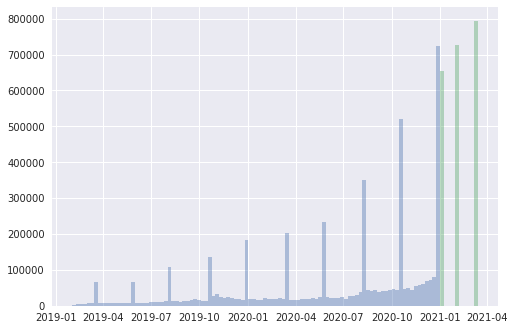

In [5]:
df[df.sample_date.between(pd.to_datetime(sample_start),
                          pd.to_datetime(sample_end))].sample_date.hist(bins=100, alpha=0.4)

df[df.sample_date > pd.to_datetime(sample_end)].sample_date.hist(bins=10, alpha=0.4)

In [6]:
static_sample_dates

['2019-03-15',
 '2019-05-27',
 '2019-08-08',
 '2019-10-20',
 '2020-01-01',
 '2020-03-14',
 '2020-05-26',
 '2020-08-07',
 '2020-10-19',
 '2020-12-31',
 '2021-01-01',
 '2021-02-01',
 '2021-03-14']

In [7]:
df.sample_date.min(), df.sample_date.max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2021-03-14 00:00:00'))

In [8]:
mmonth = "202104"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"

train_start = pd.to_datetime("2019-01-16")
train_end = pd.to_datetime("2020-12-31")
valid_dates = [pd.to_datetime(d) for d in ["2021-01-01", "2021-02-01"]]

In [9]:
train_df = df[df.sample_date.between(train_start, train_end)]
test_df = df[df.sample_date.isin(valid_dates)]
train_df.shape, test_df.shape

((4656758, 91), (1381296, 91))

<AxesSubplot:>

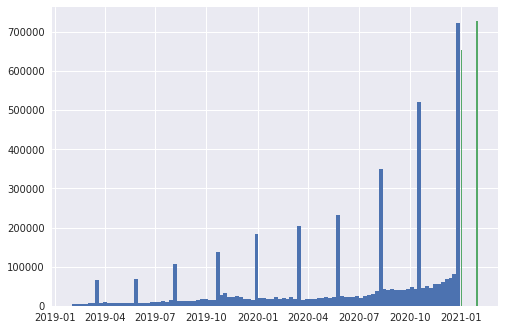

In [10]:
train_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=10)

In [11]:
train_df.to_parquet(os.path.join(s3_base_path, "dev_train_20201231.parquet"))
test_df.to_parquet(os.path.join(s3_base_path, "dev_test_20210101_20210201.parquet"))

### Target and Inde statistics
---

In [12]:
train_df[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.598379
        True             0.364380
True    False            0.028351
        True             0.008890
dtype: float64

In [13]:
train_df[["is_static", "target"]].value_counts(normalize=True).sort_index()

is_static  target
False      False     0.469048
           True      0.031609
True       False     0.493711
           True      0.005632
dtype: float64

Dynamic sampling contributes a large number of true targets, which is among the purposes of employing this method -> we would like to capture such behaviors around transactional actions.

In [14]:
test_df[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.189162
        True             0.803561
True    False            0.004209
        True             0.003067
dtype: float64